In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn
import torch.distributions as dists
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.distributions.distribution import Distribution
from np_utils import simple_data, curved_data, planck_des_data
from torch_utils import rotation_test, get_limits, TrainUtil
from tension_net import TensionNet, TensionNet1, TensionNet2, TensionNet3, TensionNet4
from tension_quantify import GaussianKDE, BayesFactorKDE, BayesFactor

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
params = ["omegabh2", "omegam", "H0", "tau", "sigma8", "ns"]
param_pairs = []
for i in range(len(params)):
    for j in range(i + 1, len(params)):
        param_pairs.append([i, j])

In [6]:
(X0, X0_weights, X1, X1_weights, X_prior, X_prior_weights,
 params, param_means, norm_factors) = planck_des_data(
     params=params, div_max=True
)
weights = { "XA": X0_weights, "XB": X1_weights, "X_prior": X_prior_weights }
param_means = torch.tensor(param_means).float().to(device)
norm_factors = torch.tensor(norm_factors).float().to(device)

In [ ]:
train_utils = []

for pair in param_pairs:
    X0_pair = X0[:, pair]
    X1_pair = X1[:, pair]
    X_prior_pair = X_prior[:, pair]
    start = time.time()
    tension_pair = TensionNet1(2, hidden_size=4096)
    criterion = BayesFactorKDE(device, n_points=500)
    optimizer = optim.Adam(tension_pair.parameters(), lr=0.0001)

    train_util_pair = TrainUtil(tension_pair, optimizer, criterion, device)
    losses_pair = train_util_pair.train(X0_pair, X1_pair, X_prior_pair,
                                        weights=weights, n_iter=500)
    
    train_utils.append(train_util_pair)
    print(f"{pair} Training time taken: ", time.time() - start)

[0, 1] Training time taken:  41.94488477706909
[0, 2] Training time taken:  41.86063241958618
[0, 3] Training time taken:  41.89744162559509
[0, 4] Training time taken:  41.869550943374634
[0, 5] Training time taken:  41.89817214012146
[1, 2] Training time taken:  41.780017137527466
[1, 3] Training time taken:  41.87988615036011
[1, 4] Training time taken:  41.78404140472412
[1, 5] Training time taken:  41.86408519744873
[2, 3] Training time taken:  41.80605959892273
[2, 4] Training time taken:  41.86274337768555
[2, 5] Training time taken:  41.84245276451111
[3, 4] Training time taken:  41.819409132003784
[3, 5] Training time taken:  41.83221220970154
[4, 5] Training time taken:  41.76991820335388


In [ ]:
repeat_idxs = [2]

for i in repeat_idxs:
    pair = param_pairs[i]
    X0_pair = X0[:, pair]
    X1_pair = X1[:, pair]
    X_prior_pair = X_prior[:, pair]
    start = time.time()
    tension_pair = TensionNet1(2, hidden_size=4096)
    criterion = BayesFactorKDE(device, n_points=500)
    optimizer = optim.Adam(tension_pair.parameters(), lr=0.001)

    train_util_pair = TrainUtil(tension_pair, optimizer, criterion, device)
    losses_pair = train_util_pair.train(X0_pair, X1_pair, X_prior_pair,
                                        weights=weights, n_iter=500,
                                        decrease_lr_at=[-8])
    
    train_utils[i] = train_util_pair
    print(f"{pair} Training time taken: ", time.time() - start)

[0, 3] Training time taken:  42.08156776428223


In [ ]:
for i, util in enumerate(train_utils):
    pair = param_pairs[i]
    torch.save(util.net.state_dict(), f"nets/pair/{pair[0]}{pair[1]}_net.pt")

In [17]:
train_utils = []
for pair in param_pairs:
    net = TensionNet1(2, hidden_size=4096)
    criterion = BayesFactorKDE(device, n_points=500)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    util = TrainUtil(net, optimizer, criterion, device)

    util.XA = X0[:, pair]
    util.XB = X1[:, pair]
    util.X_prior = X_prior[:, pair]
    util.weights = {}
    util.weights["XA"] = torch.tensor(X0_weights).to(device).float()
    util.weights["XB"] = torch.tensor(X1_weights).to(device).float()
    util.weights["X_prior"] = torch.tensor(X_prior_weights).to(device).float()

    util.XA_tnsr = torch.tensor(util.XA).to(device).float()
    util.XB_tnsr = torch.tensor(util.XB).to(device).float()
    util.X_prior_tnsr = torch.tensor(util.X_prior).to(device).float()

    train_utils.append(util)

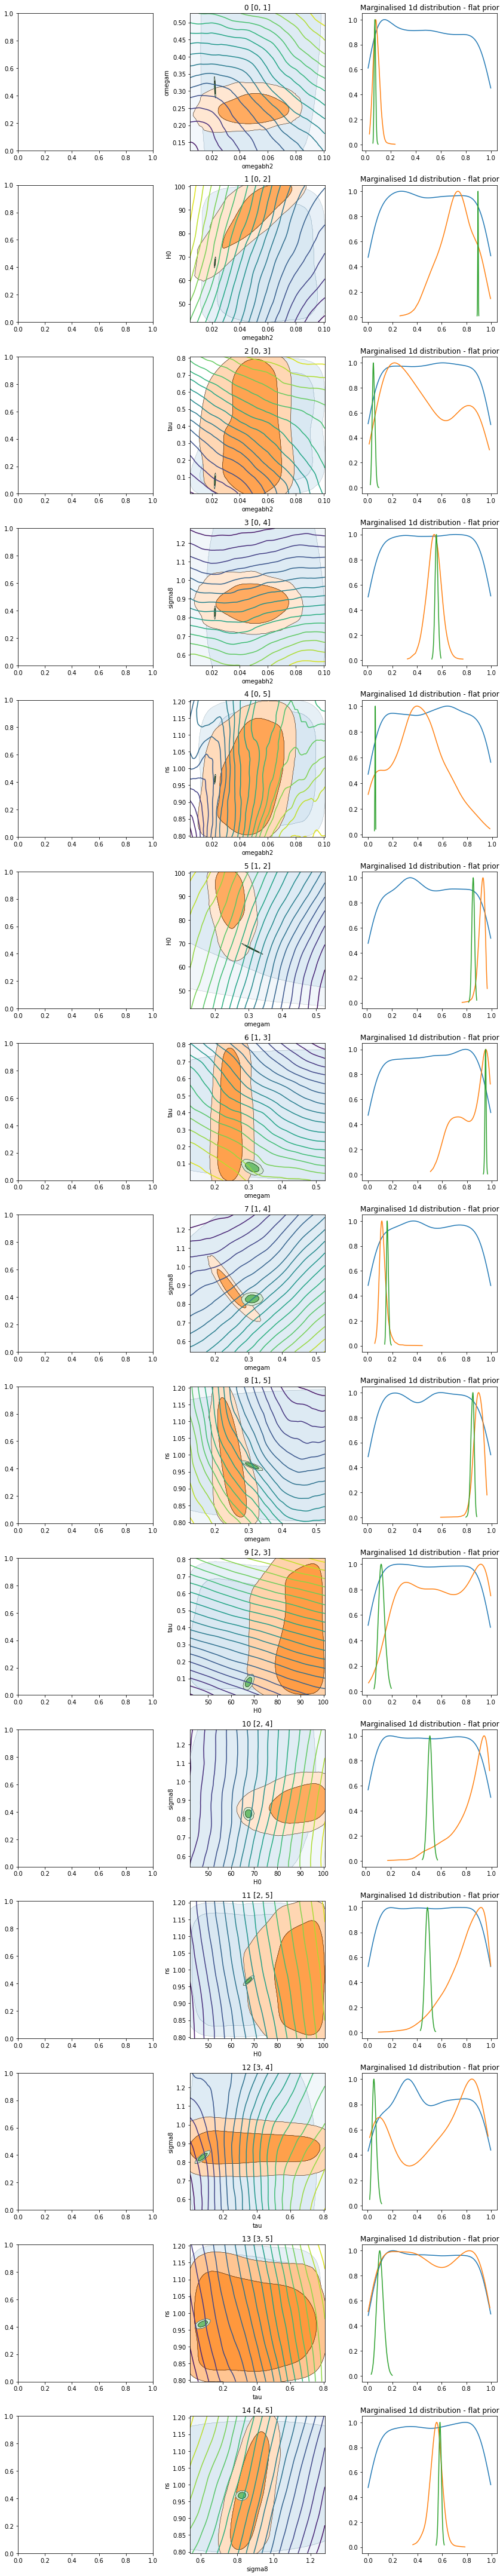

In [18]:
fig, axs = plt.subplots(len(train_utils), 3, figsize=(12, 4*len(train_utils)))

for i, tutil in enumerate(train_utils):
    # tutil.plot_loss(axs[i, 0])
    tutil.visualise_coordinate(
        axs[i, 1], focus='both', pad_div=100, swap_order=True,
        param_means=param_means[param_pairs[i]],
        norm_factors=norm_factors[param_pairs[i]]
    )
    axs[i, 1].set_xlabel(params[param_pairs[i][0]])
    axs[i, 1].set_ylabel(params[param_pairs[i][1]])
    axs[i, 1].set_title(f"{i} {param_pairs[i]}")
    tutil.plot_marginalised_dists(axs[i, 2], flat_prior=True, swap_order=True)

fig.tight_layout()